In [5]:
import os
import numpy as np
import random
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial

from keras.utils import np_utils

%matplotlib inline


In [6]:
DATA_DIR = '/Users/james/Documents/Data/genre classification/' 
AUDIO_DIR = DATA_DIR + 'Audio' 
NPZ_DIR = DATA_DIR + 'npz'

#TRAIN_TEST_HOLD_OUT_PROP = 0.7
TEST_PROP = 0.1
TRAIN_TEST_SPLIT = 0.7

POOL_SIZE = 16

Data functions


In [7]:
def get_downloaded_track_ids(directory):
    """
    Collect the track_ids from the tracks that have downloaded in the specific directory
    :return: ist of track ids
    """    
    track_ids = []
    for _, dirnames, files in os.walk(directory):
        if dirnames == []:
            track_ids.extend(str(file[:-4]) for file in files) # 4 spots before the '.mp3'
    return track_ids

In [8]:
def get_audio_path(directory, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    """
    return os.path.join(directory, track_id + '.mp3')

In [9]:
# get the successfully downloaded track id's  
track_ids = get_downloaded_track_ids(AUDIO_DIR)
print(len(track_ids))


2893


Audio Processing Functions 


In [10]:
def create_spectogram(track_id):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T   


In [11]:
def plot_spect(track_id):
    spect = create_spectogram(track_id)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


(2584, 128)


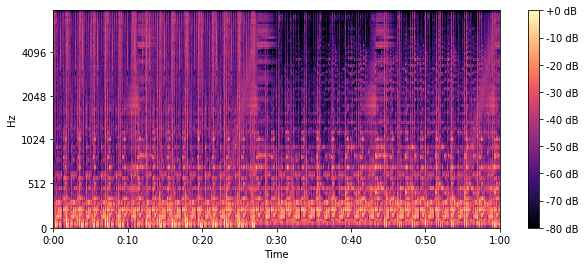

6197c792-63b8-437b-9dda-baf4c084c9db


In [12]:
# example plot
plot_spect(track_ids[0])
print(track_ids[0])


Load in track genre meta data from CSV and construct training/test split


In [13]:
# load in data from csv and filter for the relevant track id's  
meta_data_df = pd.read_csv(DATA_DIR + 'Descriptive/Genre Definitions - All Genres.csv')
print(meta_data_df.shape[0])
meta_data_df = meta_data_df[meta_data_df['guid'].isin(track_ids)]
print(meta_data_df.shape[0])
keep_cols = ['guid','genre']
meta_data_df = meta_data_df[keep_cols] 


2899
2892


In [14]:
# train/valid/test
test_idx = random.sample(meta_data_df.index.tolist(),
                        int(TEST_PROP*meta_data_df.shape[0]))
# remainder is train + valid
train_valid_idx = meta_data_df.index[~np.isin(meta_data_df.index, test_idx)]

train_idx = random.sample(train_valid_idx.tolist(),
                          int(TRAIN_TEST_SPLIT*meta_data_df.shape[0]))
valid_idx = train_valid_idx[~np.isin(train_valid_idx, train_idx)]
print(len(meta_data_df.index))
print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))
assert len(train_idx) + len(valid_idx) + len(test_idx) == len(meta_data_df.index), "train/test split not equal to total"


2892
2024
579
289


In [15]:
meta_data_df['split'] = np.where(np.isin(meta_data_df.index, train_idx), 
                                 'train', 
                                 np.where(np.isin(meta_data_df.index, valid_idx), 
                                          'valid',
                                          'test'
                                          )
                                 )
meta_data_df.head()


,guid,genre,split
0,f7e7a01b-0661-454b-81b0-daa747adf6c7,Afro House,train
1,12722a88-4b30-4f88-8ded-815265f2b051,Afro House,valid
2,75ceb7f7-b249-4690-a2b6-be78980f1f2f,Afro House,train
3,cfdf409f-87bf-4578-b08d-555edf00bdf7,Afro House,train
4,f9fd8216-ac2e-4b73-b4b7-2da25f74c677,Afro House,valid


In [16]:
meta_data_df.groupby('split')['guid'].count()


split
test      289
train    2024
valid     579
Name: guid, dtype: int64

#### Group Genres Together 


In [17]:
# proportion of genres
meta_data_df.groupby(['genre','split']).count().head(10)


guid
genre      split      
Afro House test     14
           train    60
           valid    26
Big Room   test      9
           train    69
           valid    21
Breaks     test      9
           train    70
           valid    20
Dance      test     11

In [18]:
genre_list = meta_data_df['genre'].unique()
genre_dict = {genre_list[i] : i for i in range(0, len(genre_list))}
genre_dict

{'Afro House': 0,
 'Big Room': 1,
 'Breaks': 2,
 'Dance': 3,
 'Deep House': 4,
 'Drum & Bass': 5,
 'Dubstep': 6,
 'Electro House': 7,
 'Electronica': 8,
 'Funk-Soul-Disco': 9,
 'Funk-Groove-Jackin-House': 10,
 'Future House': 11,
 'Garage-Bassline-Grime': 12,
 'Glitch': 13,
 'Hard Dance': 14,
 'Hard Techno': 15,
 'Hip-Hop': 16,
 'House': 17,
 'Indie Dance': 18,
 'Leftfield Bass': 19,
 'Leftfield House and Techno': 20,
 'Minimal Deep Tech': 21,
 'Progressive House': 22,
 'Psy-Trance': 23,
 'Reggae and Dancehall': 24,
 'Tech House': 25,
 'Techno': 26,
 'Trance': 27,
 'Trap': 28}

In [19]:
club_genres = ['Afro House', 'Big Room', 'Dance', 'Deep House', 'Electro House', 'Funk-Soul-Disco', 
               'Funk-Groove-Jackin-House', 'Future House', 'Hard Dance', 'Hard Techno', 'House',
               'Psy-Trance', 'Tech House', 'Techno', 'Trance']  
meta_data_df['genre_target'] = np.where(meta_data_df['genre'].isin(club_genres), 'club', 'bass-other') 
meta_data_df.groupby('genre_target')['guid'].count()


genre_target
bass-other    1394
club          1498
Name: guid, dtype: int64

In [20]:
meta_data_df.to_pickle(DATA_DIR + '/meta_data.pkl')

In [20]:
genre_target_list = meta_data_df['genre_target'].unique()
genre_target_dict = {genre_target_list[i] : i  for i in range(0,len(genre_target_list))}
print(genre_target_dict)

{'club': 0, 'bass-other': 1}


#### Genre Spectram Examples


##### Club


46274bfb-3a71-4ef7-81fe-b85ecd69c2bc
(2584, 128)


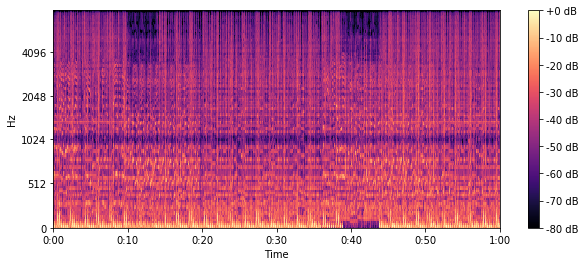

In [18]:
# club
rand_club_track = np.random.choice(meta_data_df.loc[meta_data_df['genre_target'] == 'club','guid'],
                                   1)
print(rand_club_track[0])
plot_spect(rand_club_track[0])


##### Bass


d3b7f59d-fe8e-457b-9705-a936ff8166b5
(2584, 128)


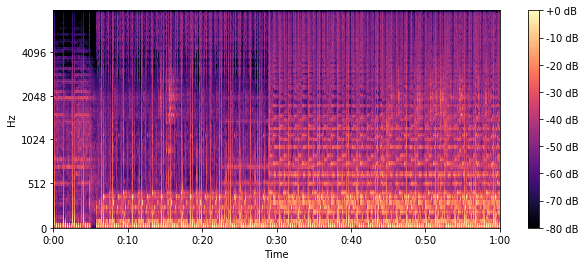

In [19]:
# bass
rand_bass_track = np.random.choice(meta_data_df.loc[meta_data_df['genre_target'] == 'bass-other','guid'],
                                   1)
print(rand_bass_track[0])
plot_spect(rand_bass_track[0])

#### Prepare Train/Test Data for Modelling Phase


In [20]:
if not os.path.exists(NPZ_DIR):
    os.makedirs(NPZ_DIR)

In [21]:
def create_features_label_array(df):
    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        try:
            count += 1
            track_id = row['guid']
            genre = str(row['genre_target'])
            spect = create_spectogram(track_id)

            # Normalize for small shape differences
            spect = spect[:640, :]
            X_spect = np.append(X_spect, [spect], axis=0)
            genres.append(genre_target_dict[genre])
            if count % 100 == 0:
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y = np.array(genres)
    return X_spect , y


In [22]:
def parallel_feature_label_creation(df, pool_size):
    """
    process the 'create_features_..' function in pools across multiple cores 
    """
    df_split = np.array_split(df, pool_size)
    pool = multiprocessing.Pool(processes=pool_size)
    results = pool.map(create_features_label_array, df_split)
    pool.close()
    pool.join()
    
    X_spect = [result[0] for result in results]
    y = [result[1] for result in results]
    
    X_spect = np.vstack(X_spect)
    y = np.concatenate(y)
    
    return X_spect, y

In [24]:
df_train = meta_data_df[meta_data_df['split'] == 'train']
df_valid = meta_data_df[meta_data_df['split'] == 'valid']
df_test  = meta_data_df[meta_data_df['split'] == 'test']

print(df_train.shape, df_valid.shape, df_test.shape)


(2024, 4) (579, 4) (289, 4)


In [47]:
X_test, y_test = create_features_label_array(df_test)
print(X_test.shape, y_test.shape)
np.savez(NPZ_DIR + '/test_array', X_test, y_test)


Currently processing:  100
Currently processing:  200


In [22]:
X_valid, y_valid = create_features_label_array(df_valid)
print(X_valid.shape, y_valid.shape)
np.savez(NPZ_DIR + '/valid_array', X_valid, y_valid)


Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
(579, 640, 128) (579,)


In [190]:
X_train, y_train = parallel_feature_label_creation(df_train, POOL_SIZE)
print(X_train.shape, y_train.shape)
np.savez(NPZ_DIR + '/train_array', X_train, y_train)


Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
Currently processing:  100
(2024, 640, 128) (2024,)


#### Scale and Shuffle Data and Convert Y to categorical (1 hot encoding)

In [22]:
# validation set X, y
npzfile = np.load(NPZ_DIR + '/valid_array.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
y_valid = np_utils.to_categorical(y_valid)
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(579, 640, 128) (579, 2)


In [23]:
# train set X, y
npzfile = np.load(NPZ_DIR + '/train_array.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
y_train = np_utils.to_categorical(y_train)
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(2024, 640, 128) (2024, 2)


In [24]:
# test set X, y
npzfile = np.load(NPZ_DIR + '/test_array.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
y_test = np_utils.to_categorical(y_test)
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(289, 640, 128) (289, 2)


In [26]:
# Convert the scale of training/valid/test data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

1e-08 1.0 0.0030753904691249037


In [27]:
X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

-18.420680743952367 0.0 -10.02069600187662


In [28]:
X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

In [29]:
# shuffle data
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [30]:
X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

print("Shapes are: ", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

Shapes are:  (2024, 640, 128) (579, 640, 128) (2024, 2) (579, 2)


In [31]:
np.savez(NPZ_DIR+'/shuffled_train', X_train, y_train)
np.savez(NPZ_DIR+'/shuffled_valid', X_valid, y_valid)
np.savez(NPZ_DIR+'/test_array', X_test, y_test)

#### Create Full-Genre Datasets

In [77]:
def create_label_array_all_genres(df):
    genres = []
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        try:
            count += 1
            track_id = row['guid']
            genre = str(row['genre'])

            # Normalize for small shape differences
            genres.append(genre_dict[genre])
            if count % 100 == 0:
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y = np.array(genres)
    return y

In [78]:
# load in
npzfile = np.load(NPZ_DIR + '/train_array.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train_all_genres= np_utils.to_categorical(create_label_array_all_genres(df_train))
print(X_train.shape, y_train_all_genres.shape)
np.savez(NPZ_DIR + '/train_array_all_genres', X_train, y_train_all_genres)

['arr_0', 'arr_1']
Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600
Currently processing:  1700
Currently processing:  1800
Currently processing:  1900
Currently processing:  2000
(2024, 640, 128) (2024, 29)


In [79]:
# valid and test
npzfile = np.load(NPZ_DIR + '/valid_array.npz')
X_valid = npzfile['arr_0']
y_valid_all_genres= np_utils.to_categorical(create_label_array_all_genres(df_valid))
print(X_valid.shape, y_valid_all_genres.shape)
np.savez(NPZ_DIR + '/valid_array_all_genres', X_valid, y_valid_all_genres)

npzfile = np.load(NPZ_DIR + '/test_array.npz')
X_test = npzfile['arr_0']
y_test_all_genres= np_utils.to_categorical(create_label_array_all_genres(df_test))
print(X_test.shape, y_test_all_genres.shape)
np.savez(NPZ_DIR + '/test_array_all_genres', X_test, y_test_all_genres)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
(579, 640, 128) (579, 29)
Currently processing:  100
Currently processing:  200
(289, 640, 128) (289, 29)


In [80]:
# Convert the scale of training/valid/test data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

1e-08 1.0 0.0030753904691249037


In [81]:
X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

-18.420680743952367 0.0 -10.02069600187662


In [82]:
X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

In [83]:
# shuffle data
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [84]:
X_train1, y_train_all_genres1 = unison_shuffled_copies(X_train_log, y_train_all_genres)
X_valid1, y_valid_all_genres1 = unison_shuffled_copies(X_valid_log, y_valid_all_genres)

print("Shapes are: ", X_train1.shape, X_valid1.shape, y_train_all_genres1.shape, y_valid_all_genres1.shape)

Shapes are:  (2024, 640, 128) (579, 640, 128) (2024, 29) (579, 29)


In [85]:
np.savez(NPZ_DIR+'/shuffled_train_all_genres', X_train1, y_train_all_genres1)
np.savez(NPZ_DIR+'/shuffled_valid_all_genres', X_valid1, y_valid_all_genres1)